# Kaggle Dog breed
Classify dog breed in Kaggle competition

In [1]:
import numpy as np

original_train_dir = './data/train'
original_test_dir = './data/test'
train_labels = np.loadtxt('./data/labels.csv', delimiter=',', dtype=str, skiprows=1)
# Remove missing data
train_labels = train_labels[train_labels[:, 0] != '000bec180eb18c7604dcecc8fe0dba07']
clazzes, counts = np.unique(train_labels[:, 1], return_counts=True)
print("Some classes with count:")
print np.asarray((clazzes, counts)).T[0:10]
print("Number of class: %d" % clazzes.size)

Some classes with count:
[['affenpinscher' '80']
 ['afghan_hound' '116']
 ['african_hunting_dog' '86']
 ['airedale' '107']
 ['american_staffordshire_terrier' '74']
 ['appenzeller' '78']
 ['australian_terrier' '102']
 ['basenji' '110']
 ['basset' '82']
 ['beagle' '105']]
Number of class: 120


## Copy data

In [2]:
import os, shutil

def mkdirIfNotExist(directory):
    if not os.path.exists(directory):
        os.mkdir(directory)
    return directory

base_dir = mkdirIfNotExist('./data/data_gen')
train_dir = mkdirIfNotExist(os.path.join(base_dir, 'train'))
validation_dir = mkdirIfNotExist(os.path.join(base_dir, 'validation'))
test_dir = mkdirIfNotExist(os.path.join(base_dir, 'test'))
for clazz in clazzes:
    mkdirIfNotExist(os.path.join(train_dir, clazz))
    mkdirIfNotExist(os.path.join(validation_dir, clazz))

In [3]:
# Copy first 600 files
def copyIfNotExist(fnames, src_dir, dst_dir):
    nCopied = 0
    for fname in fnames:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)
        if not os.path.exists(dst):
            shutil.copyfile(src, dst)
            nCopied += 1
    if nCopied > 0:
        print("Copied %d to %s" % (nCopied, dst_dir))

            
train_ratio = 1.0
for clazz in clazzes:
    fnames = train_labels[train_labels[:, 1] == clazz][:,0]
    fnames = ['{}.jpg'.format(name) for name in fnames]
    idx = int(len(fnames)*train_ratio)
    train_fnames = fnames[:idx]
    val_fnames = fnames[idx:]
    train_class_dir = os.path.join(train_dir, clazz)
    validation_class_dir = os.path.join(validation_dir, clazz)
    copyIfNotExist(train_fnames, original_train_dir, train_class_dir)
    copyIfNotExist(val_fnames, original_train_dir, validation_class_dir)

Copied 80 to ./data/data_gen/train/affenpinscher
Copied 116 to ./data/data_gen/train/afghan_hound
Copied 86 to ./data/data_gen/train/african_hunting_dog
Copied 107 to ./data/data_gen/train/airedale
Copied 74 to ./data/data_gen/train/american_staffordshire_terrier
Copied 78 to ./data/data_gen/train/appenzeller
Copied 102 to ./data/data_gen/train/australian_terrier
Copied 110 to ./data/data_gen/train/basenji
Copied 82 to ./data/data_gen/train/basset
Copied 105 to ./data/data_gen/train/beagle
Copied 89 to ./data/data_gen/train/bedlington_terrier
Copied 114 to ./data/data_gen/train/bernese_mountain_dog
Copied 77 to ./data/data_gen/train/black-and-tan_coonhound
Copied 102 to ./data/data_gen/train/blenheim_spaniel
Copied 85 to ./data/data_gen/train/bloodhound
Copied 85 to ./data/data_gen/train/bluetick
Copied 72 to ./data/data_gen/train/border_collie
Copied 91 to ./data/data_gen/train/border_terrier
Copied 75 to ./data/data_gen/train/borzoi
Copied 86 to ./data/data_gen/train/boston_bull
Copi

## Data generator

In [4]:
from keras.preprocessing.image import ImageDataGenerator

rescale_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.1
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(rescale_size, rescale_size),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(rescale_size, rescale_size),
        batch_size=batch_size,
        class_mode='categorical')

Using TensorFlow backend.


Found 10221 images belonging to 120 classes.
Found 0 images belonging to 120 classes.


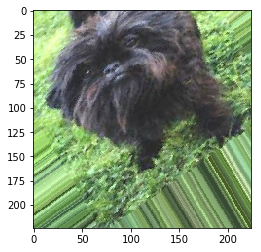

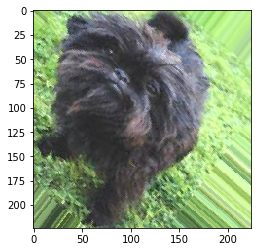

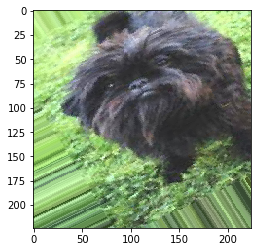

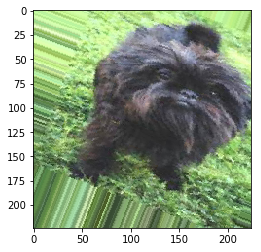

In [5]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

train_first_dir = os.path.join(train_dir, clazzes[0])
fnames = [os.path.join(train_first_dir, fname) for fname in os.listdir(train_first_dir)]

img_path = fnames[3]
img = image.load_img(img_path, target_size=(rescale_size, rescale_size))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

## Extract feature with pretrained model

In [6]:
from keras.applications import VGG16
from keras.applications.inception_v3 import InceptionV3, decode_predictions

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(rescale_size, rescale_size, 3))
conv_base.trainable = False

## Define Neural Net

In [7]:
from keras import layers, models, regularizers, optimizers
from keras.models import Sequential,  Model
from keras.layers import Flatten, Dense, Dropout

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.90),
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              52429824  
_________________________________________________________________
dense_2 (Dense)              (None, 120)               123000    
Total params: 74,355,608
Trainable params: 52,552,824
Non-trainable params: 21,802,784
_________________________________________________________________


## Train model

In [9]:

total_img_count = len(train_labels)
history = model.fit_generator(
      train_generator,
      steps_per_epoch=int(total_img_count * train_ratio / batch_size),
      epochs=20,
#       validation_data=validation_generator,
#       validation_steps=int(total_img_count * (1-train_ratio) / batch_size)
)

model.save('dog_breed_pretrain_inception_v3.h5py')

Epoch 1/20
319/319 [==============================] - 270s - loss: 4.1462 - acc: 0.1486   
Epoch 2/20
319/319 [==============================] - 263s - loss: 2.2782 - acc: 0.4626   
Epoch 3/20
319/319 [==============================] - 262s - loss: 1.6230 - acc: 0.5670   
Epoch 4/20
319/319 [==============================] - 262s - loss: 1.3526 - acc: 0.6307   
Epoch 5/20
319/319 [==============================] - 262s - loss: 1.2297 - acc: 0.6529   
Epoch 6/20
319/319 [==============================] - 262s - loss: 1.1128 - acc: 0.6843   
Epoch 7/20
319/319 [==============================] - 262s - loss: 1.0434 - acc: 0.7026   
Epoch 8/20
319/319 [==============================] - 262s - loss: 0.9862 - acc: 0.7147   
Epoch 9/20
319/319 [==============================] - 262s - loss: 0.9280 - acc: 0.7266   
Epoch 10/20
319/319 [==============================] - 262s - loss: 0.8545 - acc: 0.7528   
Epoch 11/20
319/319 [==============================] - 262s - loss: 0.8296 - acc: 0.7601 

## Evaluation

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')

plt.show()

KeyError: 'val_acc'

In [11]:
from keras.preprocessing import image
import numpy as np

def load_test_image(fpath):
    img = image.load_img(fpath, target_size=(rescale_size, rescale_size))
    x = image.img_to_array(img)
    return x

test_labels = np.loadtxt('./data/sample_submission.csv', delimiter=',', dtype=str, skiprows=1)
test_images = []
test_names = test_labels[:,0]
for test_name in test_names:
    fname = '{}.jpg'.format(test_name)
    data = load_test_image(os.path.join(original_test_dir, fname))
    test_images.append(data)

test_images = np.asarray(test_images)
test_images = test_images.astype('float32')
test_images /= 255
print(test_images.shape)

(10357, 224, 224, 3)


In [12]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions
predictions = model.predict(test_images, verbose=1)

10357/10357 [==============================] - 92s    


In [13]:
import pandas as pd
class_indices = sorted([ [k,v] for k, v in train_generator.class_indices.items() ], key=lambda c : c[1])
columns = [b[0] for b in class_indices]
df = pd.DataFrame(predictions,columns=columns)
df = df.assign(id = test_names)
print(df.head())

df.to_csv("submit.csv", index=False)

   affenpinscher  afghan_hound  african_hunting_dog      airedale  \
0   3.064835e-07  5.085903e-08         3.460309e-08  3.363536e-10   
1   4.483464e-06  7.423641e-07         5.345886e-07  2.403489e-07   
2   3.188572e-07  2.237113e-03         6.819565e-07  3.054841e-07   
3   9.144114e-04  1.406003e-02         1.373831e-06  1.274768e-06   
4   1.838730e-02  1.205004e-04         2.770447e-06  1.697407e-06   

   american_staffordshire_terrier   appenzeller  australian_terrier  \
0                    5.569715e-09  2.410608e-08        1.244520e-08   
1                    2.974534e-05  8.734321e-06        5.499269e-07   
2                    1.607632e-07  2.547701e-08        6.201422e-08   
3                    2.422037e-05  3.039281e-05        1.079035e-05   
4                    2.503256e-06  2.488597e-05        3.526600e-06   

        basenji        basset        beagle                ...                 \
0  1.272200e-08  1.590307e-07  1.606148e-08                ...               